# Machine Failure Prevention with Predictive Maintenance  

## Introduction  

FOSS Proprietary, Inc is gathering several types of data for its fleet of servers.  These servers have three operating modes: *normal*, *faulty* and *failed*.   The servers run all the time, and usually they are in normal mode.  However, in the event that the server enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode.

They collect four kinds of timeseries data for each server.  When a server is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a server fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a server fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

## Process  

This is a demonstration of using Fast Fourier Transformation (FFT) to obtain signature frequency and amplitude patterns in timeseries for use in prediction of operating modes.

In [487]:
# Use subprocess.check_call to install libraries, packages, etc. that you do not already have
import subprocess
# subprocess.check_call(["python","-m","pip","install","scikit-learn"])

In [2]:
import os
import pandas as pd
import matplotlib
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter,MonthLocator,SecondLocator
import numpy as np
from datetime import datetime, timedelta
import itertools
from itertools import accumulate
import math
import statistics

**Inspect Data**  

In [3]:
# convert csv's to dataframe's
def csv2df(path):
    dfs=[]
    for fname in os.listdir(path):
        fpath=os.path.join(path,fname)
        if os.path.isfile(fpath):
            (fil,ext)=os.path.splitext(fname)
            if ext=='.csv':
                df=pd.read_csv(fpath,error_bad_lines=False, index_col=False, dtype='unicode')
                dfs.append(df)
            else:
                continue
    return dfs
df=csv2df('foss_proprietary_data')

In [4]:
# check for missing values in data
nulls=[i.isnull().sum() for i in df]
nullz=[]
x=0
for i in nulls:
    j=list(i)
    k=j.count(x)
    nullz.append(k)
nullz=nullz.count(x)    
print('There are {} missing values in the data.'.format(nullz))

There are 0 missing values in the data.


In [5]:
# view first five rows of first csv
df=csv2df('foss_proprietary_data')
df[0].head()

,Unnamed: 0,0,1,2,3
0,2019-01-01 00:00:00.000000000,12.626096305040832,8.803119792432655,-11.809200175576045,10.08396113167012
1,2019-01-01 08:00:09.603201067,10.831994043875898,2.816327017562873,11.554777694964177,21.89285288708263
2,2019-01-01 16:00:19.206402134,21.08351002126693,-0.6726445850209626,-17.839178103236247,-1.3490236304093648
3,2019-01-02 00:00:28.809603201,32.2944947128247,6.525131508232635,-13.498585696204032,-4.250751619890839
4,2019-01-02 08:00:38.412804268,28.057099625227075,3.6913587389652744,21.98474409704879,13.670561149614247


In [6]:
print(type(df[0]['Unnamed: 0'][0]))
print(type(df[0]['0'][0]))

<class 'str'>
<class 'str'>


First column, 'Unnamed: 0', comprises date and time in string format. The remaining four columns are strings of float type.

**Use csv2df() to convert all csv files to dataframes, with 'Unnamed: 0' renamed to 'Datetime', all values in 'Datetime' converted to datetime with pandas, all other values rounded to five decimal places, and rename the timeseries columns**

In [7]:
def csv2df(path):
    dfs=list()
    for fname in os.listdir(path):
        fpath=os.path.join(path,fname)
        if os.path.isfile(fpath):
            (fil,ext)=os.path.splitext(fname)
            if ext=='.csv':
                df=pd.read_csv(fpath,error_bad_lines=False, index_col=False, dtype='unicode')
                dfr=df.rename(columns={'Unnamed: 0': 'Datetime'}).copy()
                dfr['Datetime'] = pd.to_datetime(dfr['Datetime'])
                dfv=(dfr.iloc[:,1:].astype(float))
                dfv.round(5)
                cols=dfv.columns.tolist()
                dfv.columns=['ts%i' % i for i in range(1, len(cols[:])+1)]
                dfv.insert(loc=0, column='Datetime', value=dfr['Datetime'])
                dfs.append(dfv)
            else:
                continue
    return dfs

In [8]:
dfs=csv2df('foss_proprietary_data')
dfs[0].head()

,Datetime,ts1,ts2,ts3,ts4
0,2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
1,2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
2,2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
3,2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
4,2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561


**Inspect Datetime for consistency between timestamps**

In [496]:
# Create list of unique differences between each timestamp
dl=list((dfs[0]['Datetime']))
dlts=list()
j=0
k=1
for i in dl:
    dta=dl[k]-dl[j]
    dlts.append(dta)
    if j < 2997:
        j+=1
    if k < 2998:
        k+=1
lset=set(dlts)
ulist=(list(lset))
uls=list()
for i in ulist:
    uls.append(i)

# View first 5 timestamp differences
uls[:5]

[Timedelta('0 days 08:00:09.603201056'),
 Timedelta('0 days 08:00:09.603201064'),
 Timedelta('0 days 08:00:09.603201066'),
 Timedelta('0 days 08:00:09.603201067'),
 Timedelta('0 days 08:00:09.603201068')]

In [497]:
# Calculate max difference
dis=list()
j=0
k=1
for i in uls:
    di=uls[k]-uls[j]
    dis.append(di)
    if j < 4:
        j+=1
    if k < 5:
        k+=1
mx=max(dis)
mx

Timedelta('0 days 00:00:00.000000008')

With max difference < 0.0000000 sec, time between timestamps is constistent through entire timeseries

**Generate descriptive statistics for the timeseries data**

In [498]:
dfs_concat = pd.concat(([i for i in dfs]))
display(dfs_concat.describe())

,ts1,ts2,ts3,ts4
count,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.002310,-0.185737,0.160426,0.294656
std,57.914469,55.542377,56.798872,56.713326
min,-326.441784,-285.538100,-299.880322,-365.362164
25%,-0.010102,-0.010187,-0.010039,-0.010113
50%,0.000065,-0.000154,0.000016,-0.000048
75%,0.010212,0.010003,0.010073,0.010129
max,319.144282,282.440976,297.623913,359.939478


Descriptive statistics reveal a symmetric bimodal distribution of all signals. The signals appear to be near the failed mode of 0 50% of the time. Signals appear to rise and/or fall between 0 and -327 25% of the time and rise and/or fall between 0 and 320 25% of the time.

**Remove micro and nanoseconds from timestamps**

In [499]:
labels=dfs[0]['Datetime']
slabels=[]
for i in labels:
    j = i.replace(microsecond=0,nanosecond=0)
    slabels.append(j)

**Create new dataframe with server timeseries averaged**

In [500]:
dtime=[]
ts1a=[]
ts2a=[]
ts3a=[]
ts4a=[]
k=1
for i in dfs:
    j=dfs[k]['Datetime']
    ts1=dfs[k]['ts1']
    ts2=dfs[k]['ts2']
    ts3=dfs[k]['ts3']
    ts4=dfs[k]['ts4']
    dtime.append(j)
    ts1a.append(ts1)
    ts2a.append(ts2)
    ts3a.append(ts3)
    ts4a.append(ts4)

In [502]:
dt_cols=list()
k=1
for i in range(len(dtime)):
    j="dtime"+str(k)
    dt_cols.append(j)
    k+=1
dftime=pd.concat(dtime,axis=1,keys=dt_cols)
dftime

,dtime1,dtime2,dtime3,dtime4,dtime5,dtime6,dtime7,dtime8,dtime9,dtime10,dtime11,dtime12,dtime13,dtime14,dtime15,dtime16,dtime17,dtime18,dtime19,dtime20
0,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000,2019-01-01 00:00:00.000000000
1,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067,2019-01-01 08:00:09.603201067
2,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134,2019-01-01 16:00:19.206402134
3,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201,2019-01-02 00:00:28.809603201
4,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268,2019-01-02 08:00:38.412804268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728,2021-09-25 15:59:21.587195728
2996,2021-09-25 23:59:31.190396800,2021-09-25 23:59:31.190396800,2021-09-25 23:59:31.190396800,2021-09-25 23:59:31.190396800,2021-09-25 23:59:31.1903

**Create one list of average timestamps from all machines**

In [503]:
dtavg=list()
for index,row in dftime.iterrows():
    ati=datetime.strftime(datetime.fromtimestamp(sum(map(datetime.timestamp,row))/len(row)),"%Y-%m-%d %H:%M:%S.%f")[:-4]
    dtavg.append(ati)
dav=pd.to_datetime(dtavg)

**Create list of time difference between each timestamp**

In [504]:
# Create list of timedeltas (time difference
# between each timestamp)
diffs=list()
s=0
t=1
for i in dav:
    while t < len(dav):
        j=dav[t]
        k=dav[s]
        l=j-k
        diffs.append(l)
        s+=1
        t+=1

**Calculate standard deviation of timedeltas to examine spread of time between each timestamp**  

Standard Deviation (std):  
1. Get mean of all numbers, 2. Subtract mean from each number and square result, 3. std = square root of mean of squared differences

In [505]:
# convert timedeltas to microseconds
intimes=list()
for i in diffs:
    seconds=i.total_seconds()
    mcsc=int(seconds * 1000000)
    intimes.append(mcsc)

In [506]:
# convert timedeltas to microseconds
intimes=list()
for i in diffs:
    seconds=i.total_seconds()
    mcsc=int(seconds * 1000000)
    intimes.append(mcsc)

# get mean of timedeltas
mtime=sum(intimes)/len(intimes)
# square differences each timedelta minus mean
sqdiffs=list()
for i in intimes:
    j=i-mtime
    k=j**2
    sqdiffs.append(k)

sqrt=math.sqrt
stdtime=sqrt(sum(sqdiffs)/len(sqdiffs))
stdtime="{:.2f}".format(stdtime)
print("stdtime :",stdtime)

stdtime : 4665.17


Standard deviation between timedeltas is 4665.17 microseconds, which is 0.004665 seconds.  Not a large difference.

**Create average lists for the 4 timeseries from all machines**

In [508]:
# Use for dataframe w/ Datetime as column, not index
tseries=list([ts1a,ts2a,ts3a,ts4a])
mean=statistics.mean
tavgs=[]

for i in tseries:
    dfts=pd.concat(i,axis=1)
    tsav=[]
    for index, row in dfts.iterrows():
        m=mean(row)
        tsav.append(m)
    tavgs.append(tsav)

In [509]:
dft=pd.DataFrame(data=tavgs)
dftr=dft.T
dftr.columns=tscolss
dftr

,ts1,ts2,ts3,ts4
0,12.588243,8.829718,-11.803474,10.083107
1,10.822199,2.795246,11.560279,21.898688
2,21.074661,-0.655051,-17.840580,-1.346748
3,32.284431,6.544655,-13.498907,-4.281704
4,28.073949,253.681988,271.983917,263.627071
...,...,...,...,...
2995,0.013339,-0.004840,0.008979,0.021192
2996,-250.014021,-0.010655,-250.015625,0.012988
2997,0.004022,-0.010029,-0.006909,-0.015833
2998,-0.000898,-0.011221,-0.003785,-0.010964


In [510]:
dftr.insert(0,'Datetime',dav)
dftr

,Datetime,ts1,ts2,ts3,ts4
0,2019-01-01 00:00:00.000,12.588243,8.829718,-11.803474,10.083107
1,2019-01-01 08:00:09.600,10.822199,2.795246,11.560279,21.898688
2,2019-01-01 16:00:19.200,21.074661,-0.655051,-17.840580,-1.346748
3,2019-01-02 00:00:28.800,32.284431,6.544655,-13.498907,-4.281704
4,2019-01-02 08:00:38.410,28.073949,253.681988,271.983917,263.627071
...,...,...,...,...,...
2995,2021-09-25 15:59:21.580,0.013339,-0.004840,0.008979,0.021192
2996,2021-09-25 23:59:31.190,-250.014021,-0.010655,-250.015625,0.012988
2997,2021-09-26 07:59:40.790,0.004022,-0.010029,-0.006909,-0.015833
2998,2021-09-26 15:59:50.390,-0.000898,-0.011221,-0.003785,-0.010964


Now we have dftr, a dataframe of averaged machine timeseries

**Create lists of each column in dataframe for plotting and analysis**

In [511]:
ts1=dftr['ts1']
ts2=dftr['ts2']
ts3=dftr['ts3']
ts4=dftr['ts4']
dt=dftr['Datetime']

**Plot entire averaged timeseries**

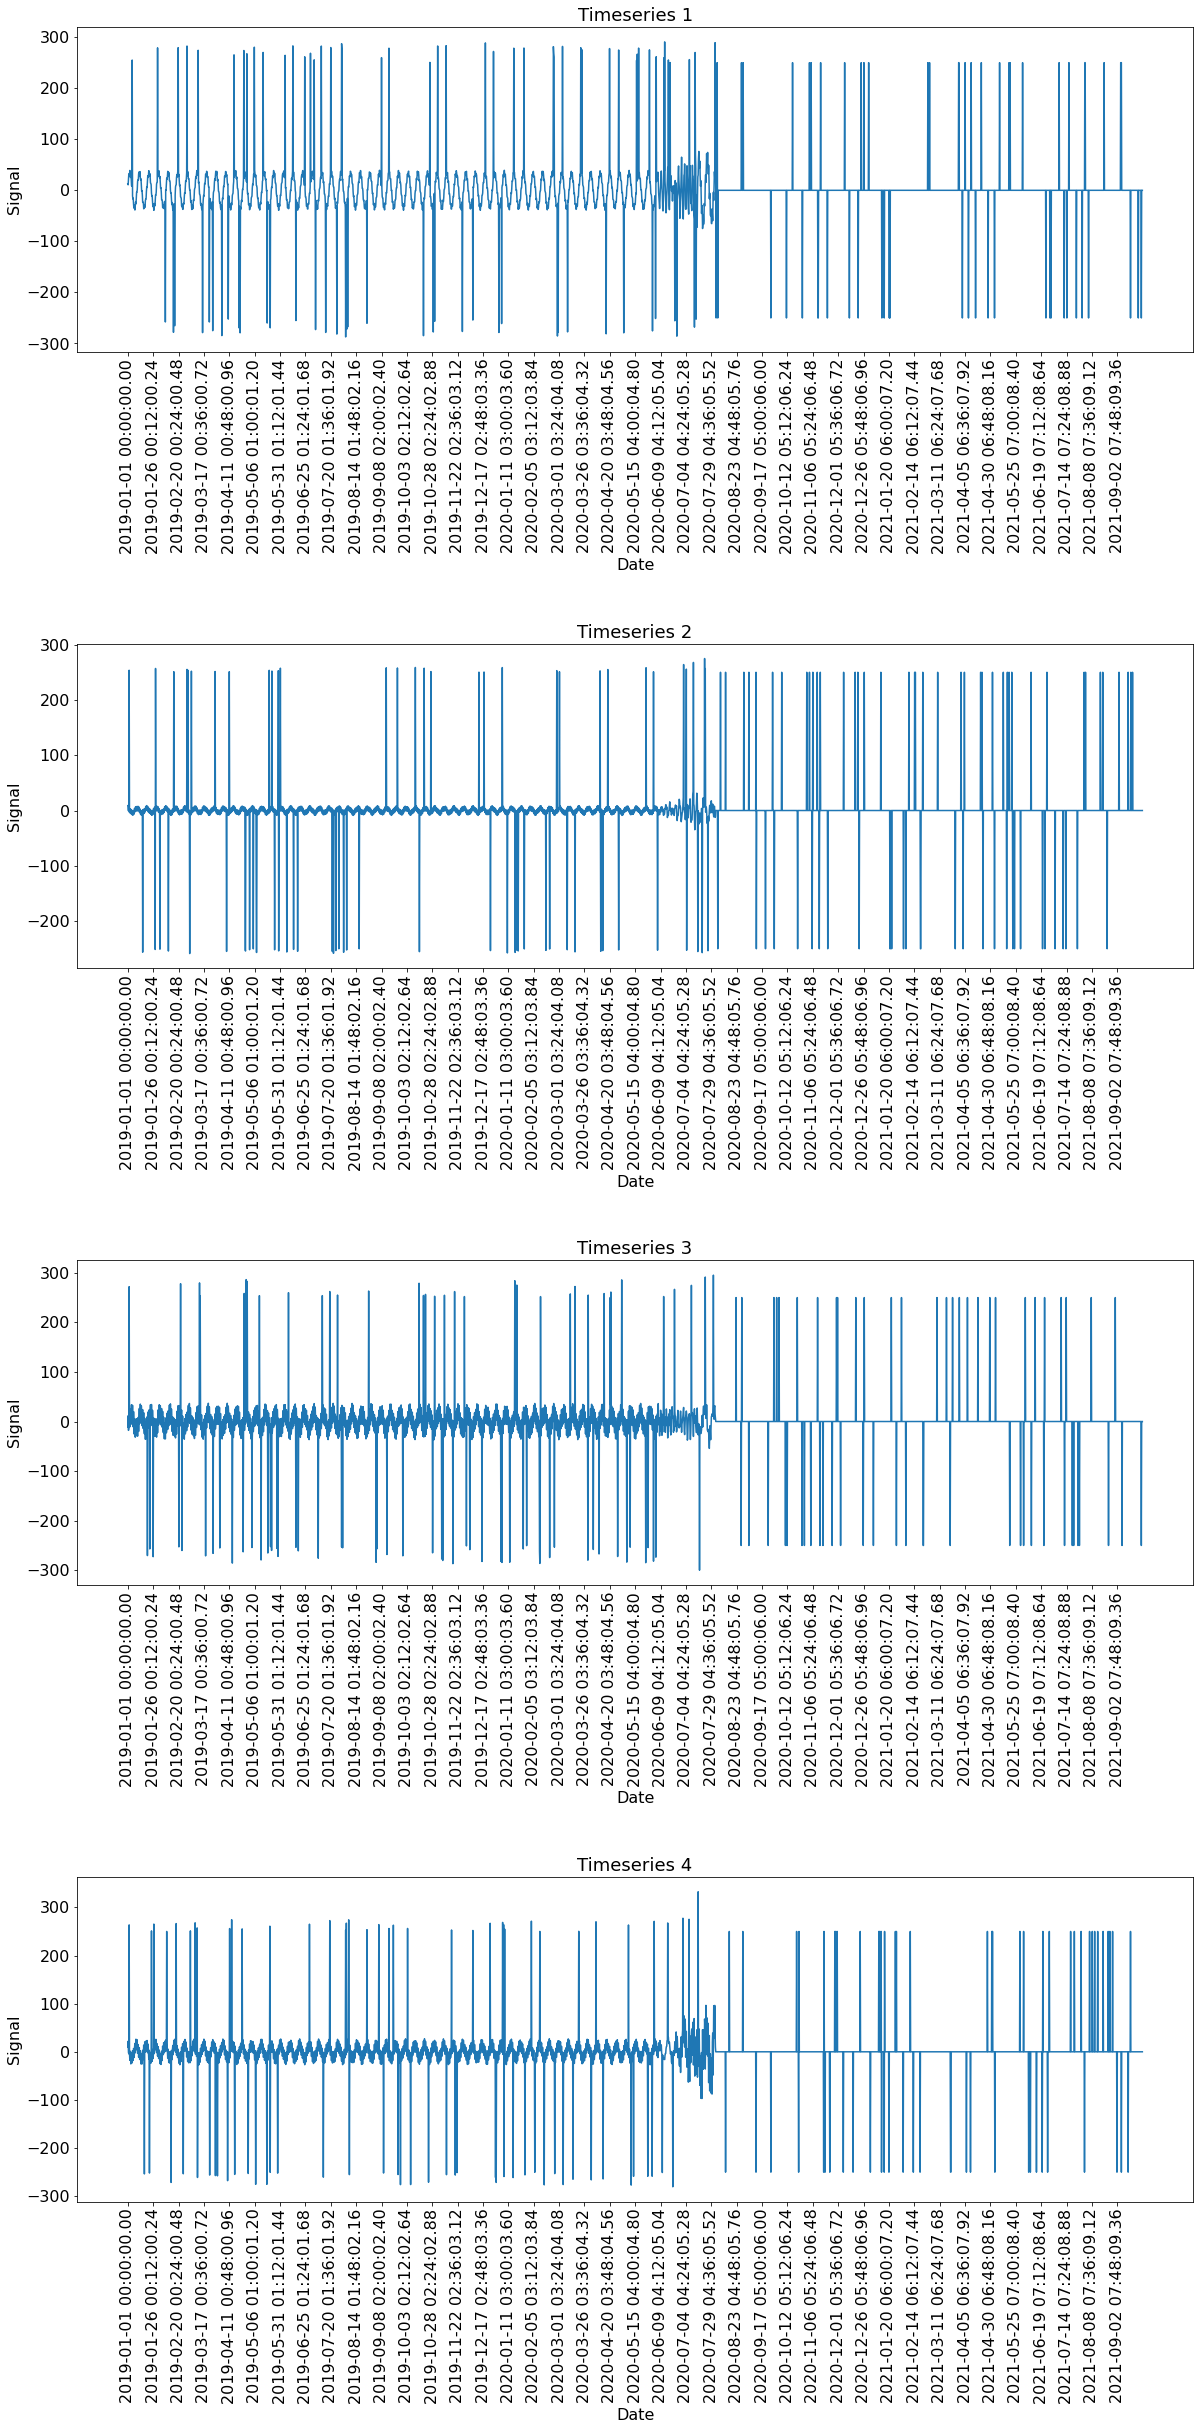

In [516]:
dtst=dt[::75]
dtlab=[(i.strftime('%Y-%m-%d %H:%M:%S.%f'))[:-4] for i in dtst]
xfmt=mdates.DateFormatter('%Y-%m-%d %H:%M:%S.%f[:-4]')
tss=[ts1,ts2,ts3,ts4]
fig, axs = plt.subplots(4)
fig.subplots_adjust(hspace=.9)
j=0
k=1
for i in tss:
    axs[j].plot(dt,i)
    axs[j].xaxis.set_major_locator(MonthLocator(bymonthday=15))
    axs[j].xaxis.set_major_formatter(xfmt)
    axs[j].set_xticks(dtst)
    axs[j].tick_params(axis='both',which='major',labelsize=16)
    axs[j].set_xticklabels(dtlab,rotation=90)
    axs[j].set_title("Timeseries " + str(k), fontsize=18)
    axs[j].set_xlabel('Date', fontsize=16)
    axs[j].set_ylabel('Signal', fontsize=16)
    j+=1
    k+=1
plt.rcParams['figure.figsize'] = [20, 40]
plt.show()

In the plot above, the normal mode appears to last until ~2020-05-15 04:00:04:80, in the middle of the plot.  At this point the data exhibits the "different" faulty mode, wherein the data exhibts different frequency and/or amplitude.  After ~1 month in the faulty mode, data signal are predominantly 0.  The extremely high and low values may be noise.

**View time period of most change: 2020-03-01 00:00:00.000 - 2020-07-01 00:00:00.000**

In [517]:
win=dt[(dt >= '2020-04-20 00:00:00.000') & (dt <= '2020-09-17 00:00:00.000')]
print("window minimum: ",min(win.index))
print("window maximum: ",max(win.index))
print("window length: ",len(win))

window minimum:  1425
window maximum:  1874
window length:  450


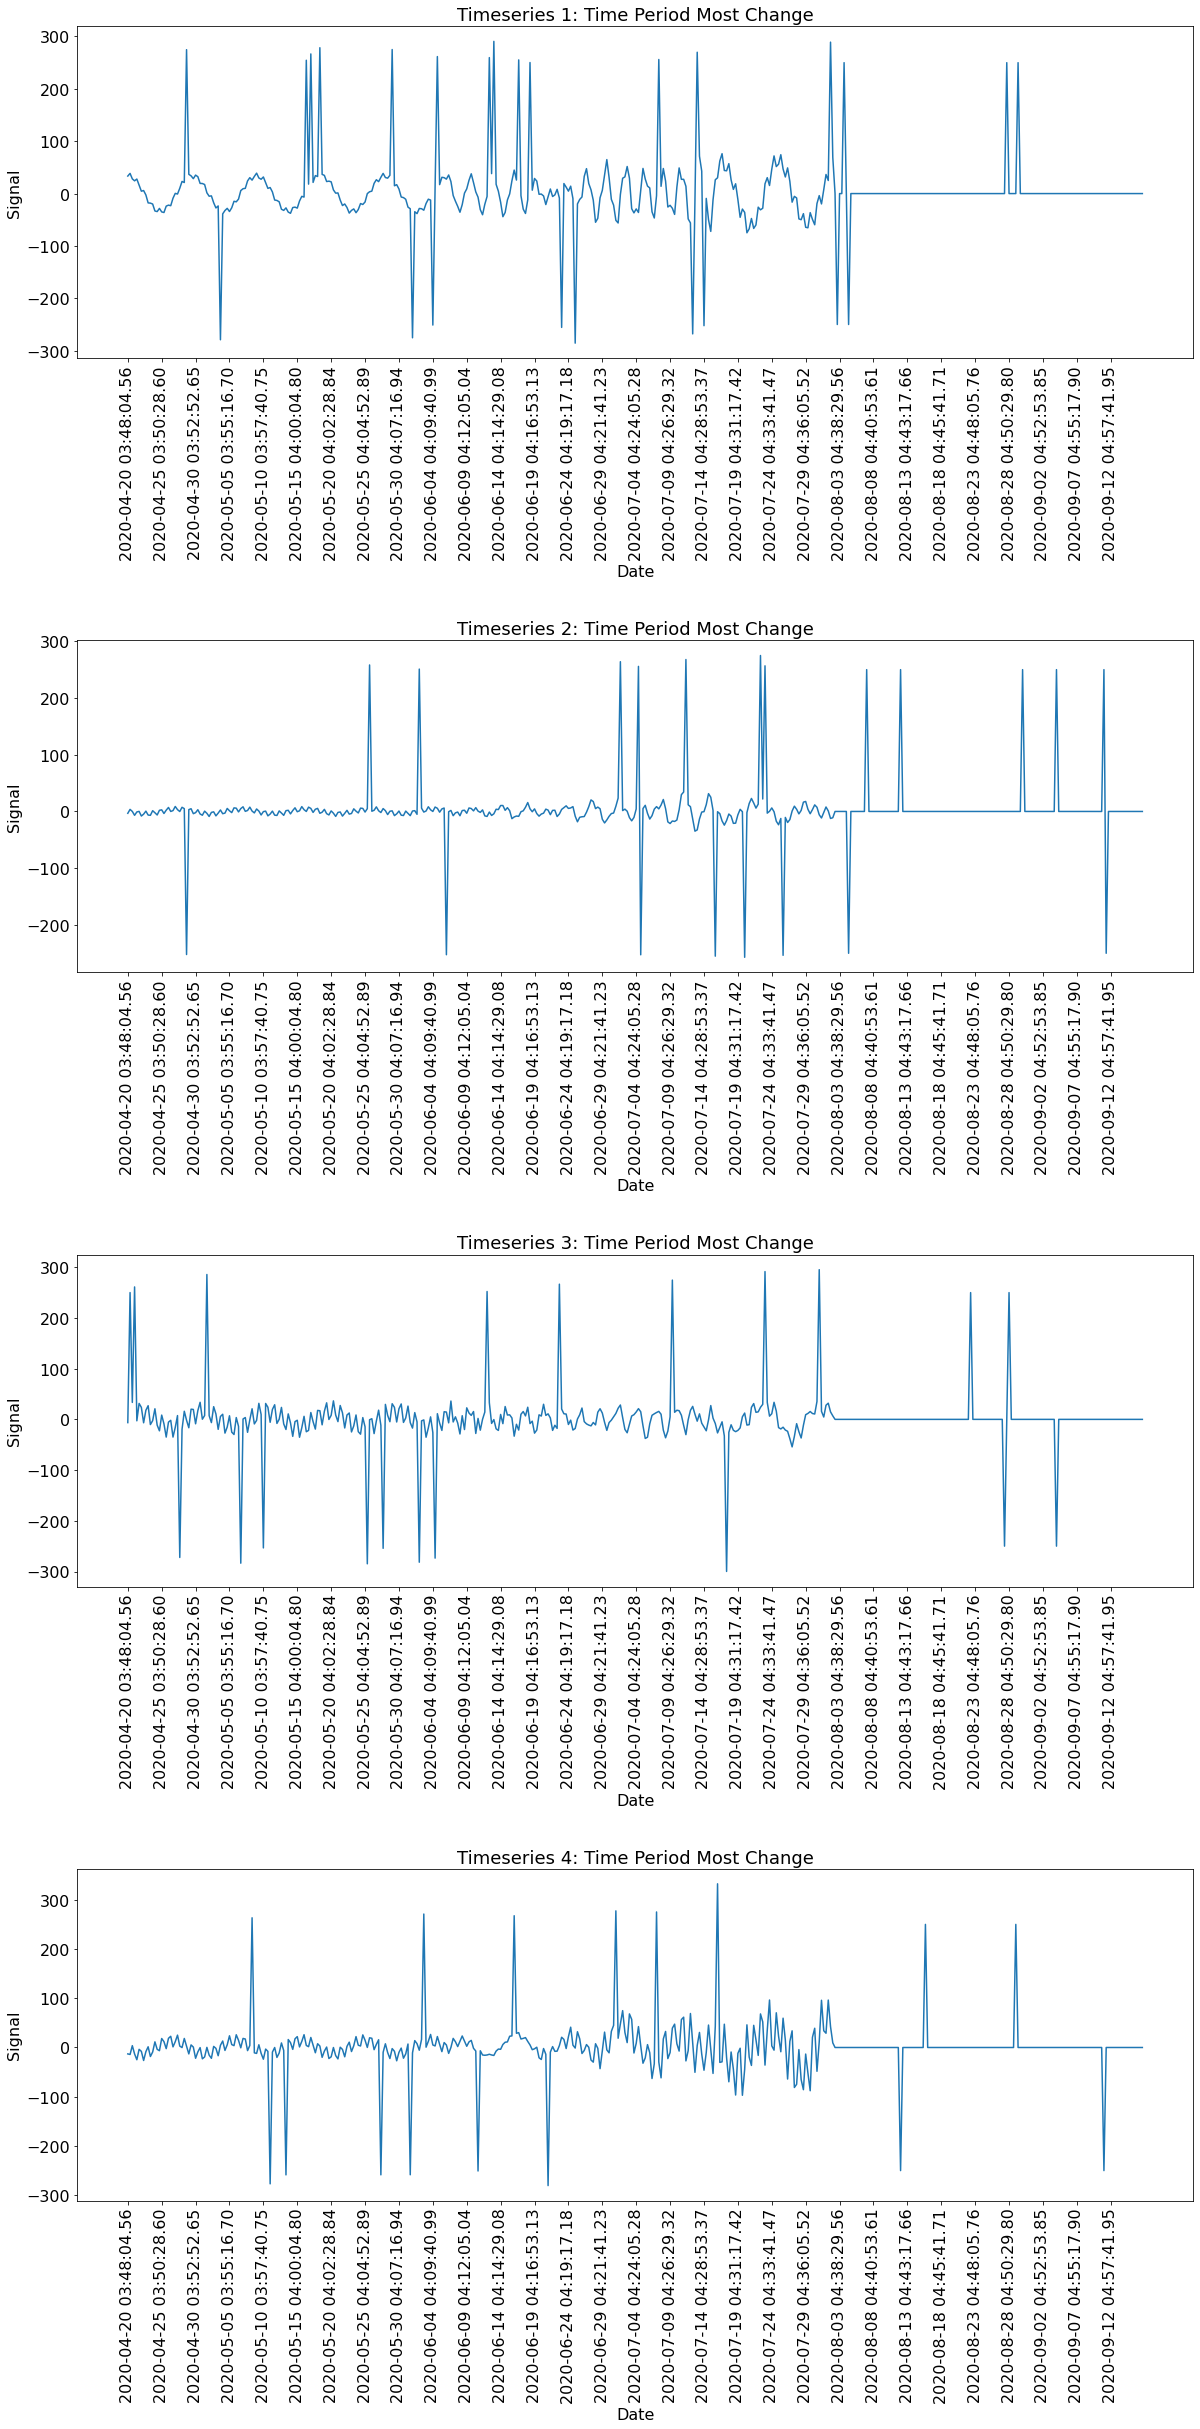

In [518]:
dtst=win[::15]
dtlab=[(i.strftime('%Y-%m-%d %H:%M:%S.%f'))[:-4] for i in dtst]
xfmt=mdates.DateFormatter('%Y-%m-%d %H:%M:%S.%f[:-4]')
tss=[ts1[1425:1875],ts2[1425:1875],ts3[1425:1875],ts4[1425:1875]]
fig, axs = plt.subplots(4)
fig.subplots_adjust(hspace=.85)
j=0
k=1
for i in tss:
    axs[j].plot(win,i)
    axs[j].xaxis.set_major_locator(MonthLocator(bymonthday=15))
    axs[j].xaxis.set_major_formatter(xfmt)
    axs[j].set_xticks(dtst)
    axs[j].tick_params(axis='both',which='major',labelsize=16)
    axs[j].set_xticklabels(dtlab,rotation=90)
    axs[j].set_title("Timeseries " + str(k) + ": Time Period Most Change", fontsize=18)
    axs[j].set_xlabel('Date', fontsize=16)
    axs[j].set_ylabel('Signal', fontsize=16)
    j+=1
    k+=1
plt.rcParams['figure.figsize'] = [20, 40]
plt.show()

Viewing this significant window, we can assume all signals above amplitude 100/-100 are noise to make characterizing normal, faulty, and failure easier.

# Timeseries Characteristics: Frequency and Amplitude

**Absolute FFT (Fast Fourier Transformation) of Timeseries in Normal Mode**  
Plots above reveal timeseries to exhibit Normal mode from start of timeseries (2019-01-01 00:00:00.000) to ~ 2020-05-25 00:00:00.000

In [519]:
winn=dt[(dt >= '2019-01-01 00:00:00.000') & (dt <= '2020-05-25 00:00:00.000')]
print("Normal window minimum: ",min(winn.index))
print("Normal window maximum: ",max(winn.index))
print("Normal window length: ",len(winn))

Normal window minimum:  0
Normal window maximum:  1529
Normal window length:  1530


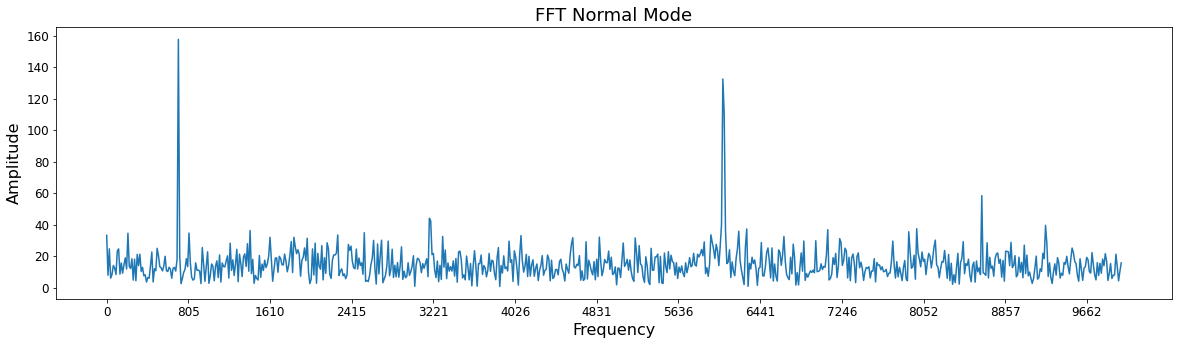

In [521]:
# Use window measurements to make lists for plots
tn=[ts1[0:1530],ts2[0:1530],ts3[0:1530],ts4[0:1530]]

# Create average list for Normal Mode
dftn=pd.DataFrame(data=tn)
dftn=dftn.T
nav=[]
for index, row in dftn.iterrows():
    m=mean(row)
    nav.append(m)

# take the absolutes of the fast fourier transform
# use 24 for sample frequency of 1 day
amp_norm = 24/(len(nav)) * np.absolute(np.fft.fft(nav))
# ignore the 2nd half of the transform as being complex conjugates of the 1st half
amp_norm = amp_norm[0:(int(len(amp_norm)/2))]
freq_norm = np.linspace(0,10000, len(amp_norm))
fig, axs = plt.subplots(1)
plt.plot(freq_norm,amp_norm)
axs.set_xticks(freq[::50])
axs.tick_params(axis='both',which='major',labelsize=12)
axs.set_title("FFT Normal Mode", fontsize=18)
axs.set_xlabel('Frequency', fontsize=16)
axs.set_ylabel('Amplitude', fontsize=16)
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

**Absolute FFT of Timeseries in Faulty Mode**  
Plots of time period with most change reveal timeseries to exhibit Faulty mode from ~ 2020-06-04 00:00:00.000 to 2020-08-08 00:00:00.000

In [522]:
winfau=dt[(dt >= '2020-06-04 00:00:00.000') & (dt <= '2020-08-08 00:00:00.000')]
print("Normal window minimum: ",min(winfau.index))
print("Normal window maximum: ",max(winfau.index))
print("Normal window length: ",len(winfau))

Normal window minimum:  1560
Normal window maximum:  1754
Normal window length:  195


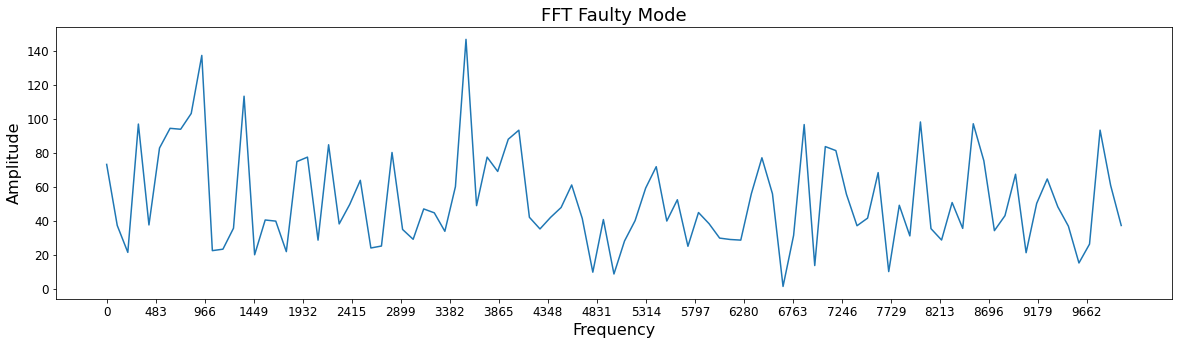

In [523]:
# Use window measurements to make lists for plots
tfau=[ts1[1560:1755],ts2[1560:1755],ts3[1560:1755],ts4[1560:1755]]

# Create average list for Normal Mode
dftn=pd.DataFrame(data=tfau)
dftn=dftn.T
nav=[]
for index, row in dftn.iterrows():
    m=mean(row)
    nav.append(m)

# take the absolutes of the fast fourier transform
# use 24 for sample frequency of 1 day
amp_faulty = 24/(len(nav)) * np.absolute(np.fft.fft(nav))
# ignore the 2nd half of the transform as being complex conjugates of the 1st half
amp_faulty = amp_faulty[0:(int(len(amp_faulty)/2))]
freq_faulty = np.linspace(0,10000, len(amp_faulty))
fig, axs = plt.subplots(1)
plt.plot(freq_faulty,amp_faulty)
axs.set_xticks(freq[::30])
axs.tick_params(axis='both',which='major',labelsize=12)
axs.set_title("FFT Faulty Mode", fontsize=18)
axs.set_xlabel('Frequency', fontsize=16)
axs.set_ylabel('Amplitude', fontsize=16)
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

**Absolute FFT of Timeseries in Failed Mode**  
Plots of time period with most change reveal timeseries to exhibit Failed mode from ~ 2020-06-04 00:00:00.000 to end of timeseries (2021-09-27 00:00:00.000)

In [524]:
winfai=dt[(dt >= '2020-08-08 00:00:00.000') & (dt <= '2021-09-27 00:00:00.000')]
print("Normal window minimum: ",min(winfai.index))
print("Normal window maximum: ",max(winfai.index))
print("Normal window length: ",len(winfai))

Normal window minimum:  1755
Normal window maximum:  2999
Normal window length:  1245


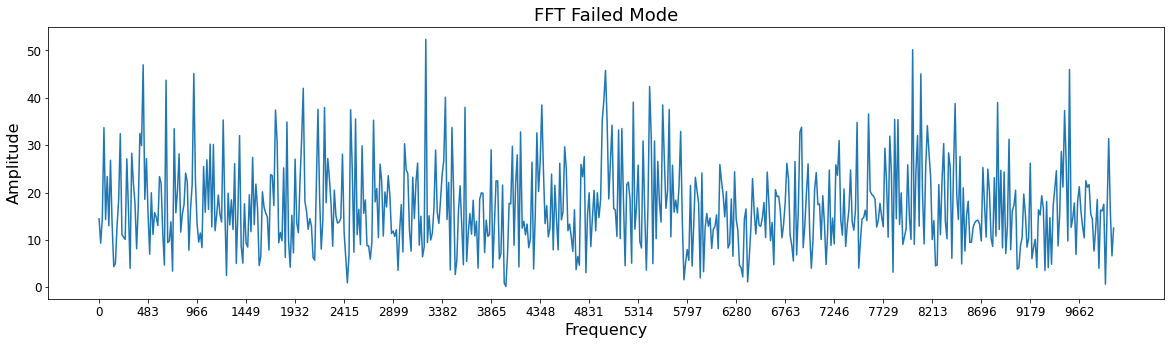

In [525]:
# Use window measurements to make lists for plots
tfai=[ts1[1755:3000],ts2[1755:3000],ts3[1755:3000],ts4[1755:3000]]
# Create average list for Normal Mode
dftn=pd.DataFrame(data=tfai)
dftn=dftn.T
nav=[]
for index, row in dftn.iterrows():
    m=mean(row)
    nav.append(m)

# take the absolutes of the fast fourier transform
# use 24 for sample frequency of 1 day
amp_failed = 24/(len(nav)) * np.absolute(np.fft.fft(nav))
# ignore the 2nd half of the transform as being complex conjugates of the 1st half
amp_failed = amp_failed[0:(int(len(amp_failed)/2))]
freq_failed = np.linspace(0,10000, len(amp_failed))
fig, axs = plt.subplots(1)
plt.plot(freq_failed,amp_failed)
axs.set_xticks(freq[::30])
axs.tick_params(axis='both',which='major',labelsize=12)
axs.set_title("FFT Failed Mode", fontsize=18)
axs.set_xlabel('Frequency', fontsize=16)
axs.set_ylabel('Amplitude', fontsize=16)
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

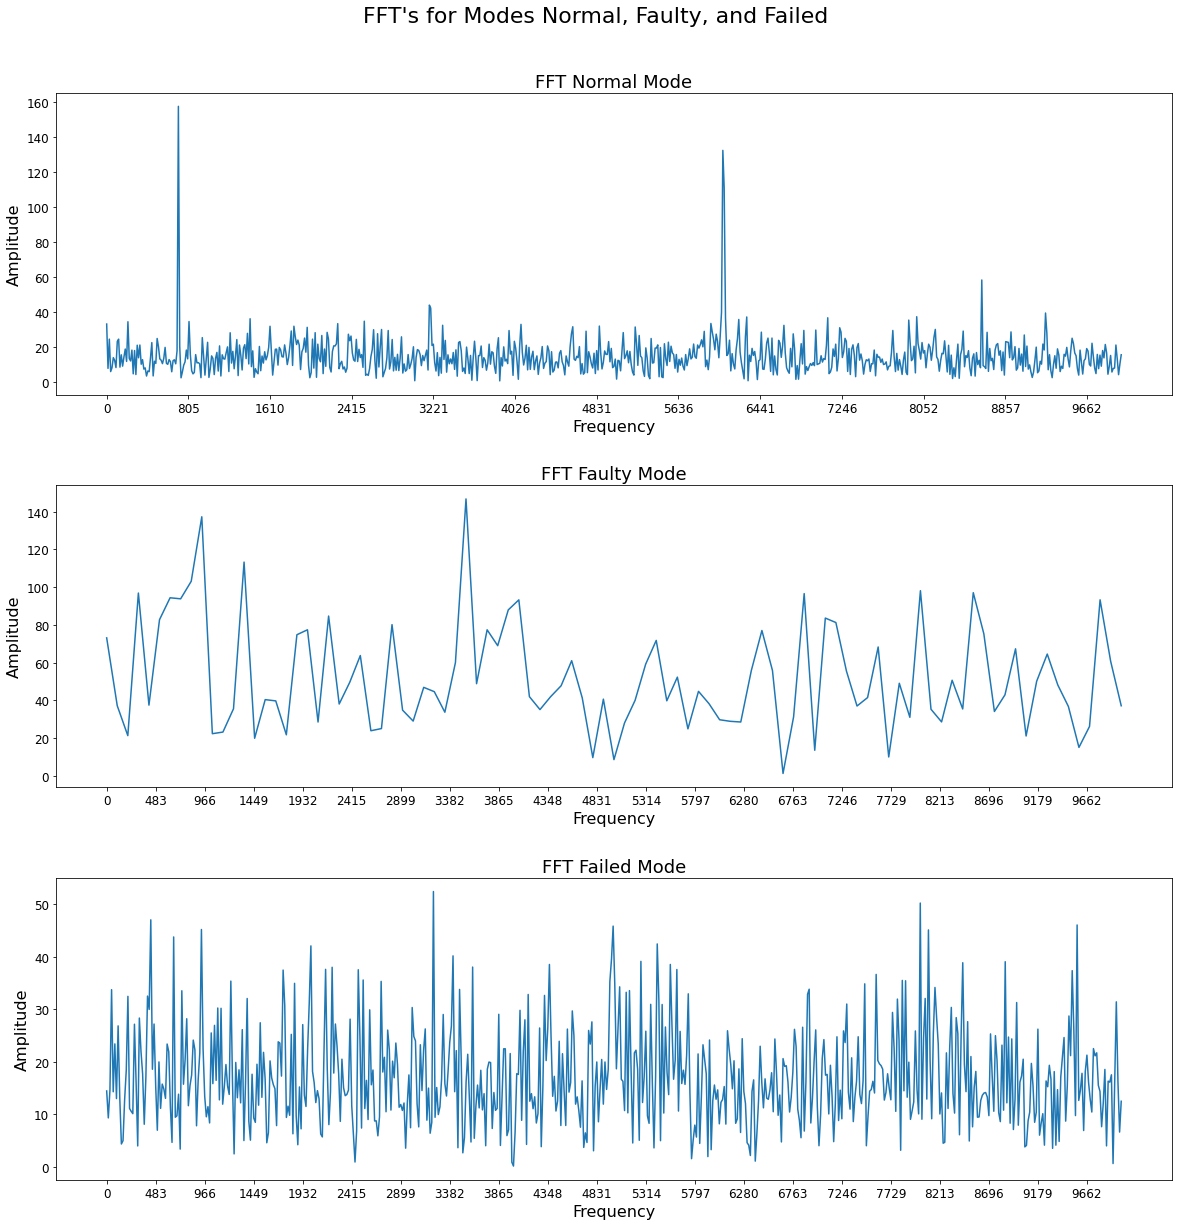

In [527]:
fig, axs = plt.subplots(3)
fig.subplots_adjust(hspace=.3)

axs[0].plot(freq_norm,amp_norm)
axs[0].set
axs[0].set_xticks(freq[::50])
axs[0].tick_params(axis='both',which='major',labelsize=12)
axs[0].set_title("FFT Normal Mode", fontsize=18)
axs[0].set_xlabel('Frequency', fontsize=16)
axs[0].set_ylabel('Amplitude', fontsize=16)

axs[1].plot(freq_faulty,amp_faulty)
axs[1].set_xticks(freq[::30])
axs[1].tick_params(axis='both',which='major',labelsize=12)
axs[1].set_title("FFT Faulty Mode", fontsize=18)
axs[1].set_xlabel('Frequency', fontsize=16)
axs[1].set_ylabel('Amplitude', fontsize=16)

axs[2].plot(freq_failed,amp_failed)
axs[2].set_xticks(freq[::30])
axs[2].tick_params(axis='both',which='major',labelsize=12)
axs[2].set_title("FFT Failed Mode", fontsize=18)
axs[2].set_xlabel('Frequency', fontsize=16)
axs[2].set_ylabel('Amplitude', fontsize=16)

fig.suptitle("FFT's for Modes Normal, Faulty, and Failed", fontsize=22, y=.94)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

# Conclusion

In order for FOSS Proprietary to shutdown a server before failure, it is recommended they utilize this data pipeline to recognize the signature amplitude/frequency of a server in Faulty mode. Thus, affording shutdown in the Faulty mode prior to Failed mode.

Given enough time and resources, machine learning approaches that utilize feature extraction and training/validation (e.g. LSTM and Random Forest) would make this data pipeline more robust.